In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import ExploratoryAnalysis.data_processing_modules as dpm
import re

c:\Users\nicho\anaconda3\envs\recSysEnv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Whats going on here
we start by reading in the news with the embedding columns
we then drop the unnamed 0 column
then we remove the columns without any values in them 
then we drop the title and abstract entities columns 
then we drop the url column

~~~ Notes for simplicity now
    For starters, we can drop 4 columns at once and then remove the NA values

We then create a function string to numpy array in order to remove all the excess noise so that the lists are list data type and can be expanded

We then remove abstract embedding columns that are false, which we should do just generally for the whole frame anyways
then we apply our function to our respective columns
then we drop the title and abstract columns since we have the embeddings now
then we dummy variable our categorical variables and drop the original columns (do we want to drop them or should we consider keeping them anyways?)
then we set the index to news id
and then we split the embeddings into lists and expand them out across the dataframe

Then we drop the extra columns

Then we cluster!! 

~~~ Final notes
We can cluster without creating the extra columns
think about implementing a normalization technique for the rows

~~~ New flow
~ load in data and drop the columns that we do not care about
~ remove all NaN values from the dataframe 
~ define function to reformat embeddings and apply to relevant columns
~ split embeddings into lists and append to the frame
~ set index to newsID
~ drop unnecessary columns 
~ then ready for umap

In [2]:
embedded_news = pd.read_csv('MIND_small/csv/news_big_embeddings.csv').drop(columns=['Unnamed: 0', 'abstract_entities', 'title_entities', 'url'])

In [3]:
embedded_news = embedded_news[embedded_news['abstract_embeddings'] != '[0]']
embedded_news = embedded_news[embedded_news['abstract_embeddings'].isna() == False]

In [4]:
embedded_news['abstract_embeddings'].to_list()[0]

'[[-0.6785084009170532, 0.5100855231285095, 0.9998178482055664, -0.9890434145927429, 0.9464158415794373, 0.8724645972251892, 0.983302116394043, -0.9892012476921082, -0.9683953523635864, -0.6799933910369873, 0.9755300283432007, 0.9979857802391052, -0.998071014881134, -0.9996988773345947, 0.758587658405304, -0.9701862931251526, 0.9776204824447632, -0.5586976408958435, -0.9999427199363708, -0.6196436285972595, -0.18786200881004333, -0.9998210668563843, 0.2224884033203125, 0.9555333256721497, 0.9658681154251099, 0.11592088639736176, 0.9800298810005188, 0.9999332427978516, 0.8478230834007263, -0.3973483145236969, 0.26341700553894043, -0.9837534427642822, 0.8118741512298584, -0.9983517527580261, 0.1409410834312439, 0.06379949301481247, 0.6075135469436646, -0.2816455066204071, 0.6020714640617371, -0.8813018798828125, -0.5990106463432312, -0.649540364742279, 0.6770514249801636, -0.5223959684371948, 0.9710656404495239, 0.11778338998556137, 0.18735989928245544, -0.0008477547089569271, -0.1152087

In [5]:
def string_to_list(input_str):
    """Reformats a column in the dataframe so that is an array and is compatible for expansion."""
    processed_string = input_str.replace("\n        ", " ").replace("[array(", "").replace('\n', '').replace(', dtype=float32)]', '')
    clean_str = ' '.join(processed_string.split())
    clean_str = clean_str.replace(', dtype=float32)]', '')
    array = list(eval(clean_str))
    return array

def simple_string_to_list(input_str):
    """Reformats separate list of embeddings so it is compatible for expansion"""    
    processed_string = input_str.replace("[[", "[").replace("]]", "]").replace('\n', '').replace(', dtype=float32)]', '')
    array = list(eval(processed_string))
    return array


In [6]:
embedded_news['abstract_embeddings'] = embedded_news['abstract_embeddings'].apply(lambda x : simple_string_to_list(x))
embedded_news['title_embeddings'] = embedded_news['title_embeddings'].apply(lambda x : simple_string_to_list(x))
umap_data = embedded_news.copy()

In [7]:
del embedded_news

In [8]:
umap_data.head()

,Unnamed: 0.1,news_id,category,sub_category,title,abstract,abstract_embeddings,title_embeddings
0,0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...","[-0.6785084009170532, 0.5100855231285095, 0.99...","[-0.7608808279037476, 0.5620608329772949, 0.99..."
1,1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,"[-0.6898252367973328, 0.4706791639328003, 0.99...","[-0.7876797318458557, 0.6151419878005981, 0.99..."
2,2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,"[-0.6491379141807556, 0.3324471712112427, 0.99...","[-0.6224949955940247, 0.46094727516174316, 0.9..."
3,3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...","[-0.6202505826950073, 0.3782839775085449, 0.99...","[-0.7408541440963745, 0.5192243456840515, 0.99..."
4,4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...","[-0.7372449636459351, 0.4566461741924286, 0.99...","[-0.6986601948738098, 0.46298423409461975, 0.9..."


In [9]:
# dumny_cats = pd.get_dummies(data=umap_data[['category', 'sub_category']], dtype=float)
# umap_data = pd.concat([umap_data, dumny_cats], axis=1)

In [10]:
umap_data.set_index('news_id', inplace=True)

In [11]:
abstracts = pd.DataFrame(umap_data['abstract_embeddings'].to_list(), index=umap_data.index)
titles = pd.DataFrame(umap_data['title_embeddings'].to_list(), index=umap_data.index)
titles.columns = ['{}_title'.format(title) for title in titles.columns]
abstracts.columns = ['{}_abstract'.format(title) for title in abstracts.columns]

In [12]:
abstracts

,0_abstract,1_abstract,2_abstract,3_abstract,4_abstract,5_abstract,6_abstract,7_abstract,8_abstract,9_abstract,...,758_abstract,759_abstract,760_abstract,761_abstract,762_abstract,763_abstract,764_abstract,765_abstract,766_abstract,767_abstract
news_id,,,,,,,,,,,,,,,,,,,,,
N55528,-0.678508,0.510086,0.999818,-0.989043,0.946416,0.872465,0.983302,-0.989201,-0.968395,-0.679993,...,0.677721,-0.131281,0.538551,-0.444421,-0.435791,-0.197555,-0.140542,0.999937,-0.683746,0.987187
N19639,-0.689825,0.470679,0.999851,-0.994703,0.969886,0.945957,0.989684,-0.996318,-0.974794,-0.706272,...,0.711166,-0.305206,0.766647,-0.613100,-0.373641,-0.565517,-0.063743,0.999955,-0.884546,0.990700
N61837,-0.649138,0.332447,0.999478,-0.975300,0.930517,0.928687,0.952428,-0.996233,-0.912072,-0.400712,...,0.480411,-0.497116,0.322929,-0.548832,-0.392572,-0.458578,-0.049935,0.999793,-0.713220,0.969965
N53526,-0.620251,0.378284,0.999805,-0.993509,0.971419,0.956017,0.990925,-0.997767,-0.974476,-0.661895,...,0.703306,-0.143778,0.770481,-0.615078,-0.343000,-0.629248,0.026013,0.999943,-0.805562,0.988447
N38324,-0.737245,0.456646,0.999699,-0.987310,0.945211,0.844170,0.972281,-0.987509,-0.938060,-0.693719,...,0.761685,-0.117997,0.125520,-0.445764,-0.291769,-0.475241,-0.179736,0.999929,-0.755804,0.974853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N17258,-0.618489,0.464543,0.999628,-0.974870,0.929978,0.757753,0.966552,-0.970493,-0.933629,-0.651518,...,0.804512,-0.174814,0.359646,-0.408471,-0.261639,-0.119483,-0.092162,0.999829,-0.574875,0.966811
N23858,-0.632591,0.450974,0.999812,-0.988964,0.946670,0.778630,0.980280,-0.977038,-0.968778,-0.662544,...,0.749621,0.092505,0.265248,-0.307172,-0.222741,-0.282915,-0.065477,0.999938,-0.468659,0.985415
N16909,-0.792380,0.611406,0.999981,-0.994471,0.969889,0.769428,0.988007,-0.911938,-0.988090,-0.712895,...,0.848486,0.321718,-0.279954,-0.088676,0.020088,0.234813,-0.376452,0.999991,-0.072645,0.992745


In [13]:
umap_data = pd.concat([umap_data, titles, abstracts], axis=1)

In [14]:
umap_data.drop(columns=['Unnamed: 0.1','abstract_embeddings','title_embeddings'], inplace=True)

In [16]:
# embedded_news.set_index('news_id', inplace=True)

NameError: name 'embedded_news' is not defined

In [17]:
umap_data.head()

,category,sub_category,title,abstract,0_title,1_title,2_title,3_title,4_title,5_title,...,758_abstract,759_abstract,760_abstract,761_abstract,762_abstract,763_abstract,764_abstract,765_abstract,766_abstract,767_abstract
news_id,,,,,,,,,,,,,,,,,,,,,
N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",-0.760881,0.562061,0.999948,-0.994303,0.949045,0.764554,...,0.677721,-0.131281,0.538551,-0.444421,-0.435791,-0.197555,-0.140542,0.999937,-0.683746,0.987187
N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,-0.787680,0.615142,0.999966,-0.993316,0.964220,0.723472,...,0.711166,-0.305206,0.766647,-0.613100,-0.373641,-0.565517,-0.063743,0.999955,-0.884546,0.990700
N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,-0.622495,0.460947,0.999873,-0.990779,0.959267,0.900435,...,0.480411,-0.497116,0.322929,-0.548832,-0.392572,-0.458578,-0.049935,0.999793,-0.713220,0.969965
N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",-0.740854,0.519224,0.999932,-0.995590,0.966713,0.854350,...,0.703306,-0.143778,0.770481,-0.615078,-0.343000,-0.629248,0.026013,0.999943,-0.805562,0.988447
N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",-0.698660,0.462984,0.999867,-0.990970,0.960319,0.645505,...,0.761685,-0.117997,0.125520,-0.445764,-0.291769,-0.475241,-0.179736,0.999929,-0.755804,0.974853


In [18]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dimension reduction and clustering libraries
import umap.umap_ as umap
import umap.plot as uplot
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [19]:
umap_data[abstracts.columns.to_list() + titles.columns.to_list()].head()

,0_abstract,1_abstract,2_abstract,3_abstract,4_abstract,5_abstract,6_abstract,7_abstract,8_abstract,9_abstract,...,758_title,759_title,760_title,761_title,762_title,763_title,764_title,765_title,766_title,767_title
news_id,,,,,,,,,,,,,,,,,,,,,
N55528,-0.678508,0.510086,0.999818,-0.989043,0.946416,0.872465,0.983302,-0.989201,-0.968395,-0.679993,...,0.784108,0.066547,0.084478,-0.474509,-0.233880,-0.330869,-0.392143,0.999986,-0.325422,0.990003
N19639,-0.689825,0.470679,0.999851,-0.994703,0.969886,0.945957,0.989684,-0.996318,-0.974794,-0.706272,...,0.923660,-0.199729,0.298200,-0.371616,-0.024119,-0.210733,-0.371494,0.999987,-0.404185,0.982506
N61837,-0.649138,0.332447,0.999478,-0.975300,0.930517,0.928687,0.952428,-0.996233,-0.912072,-0.400712,...,0.756771,-0.275562,0.560876,-0.562148,-0.324376,-0.294702,-0.252834,0.999979,-0.583293,0.985602
N53526,-0.620251,0.378284,0.999805,-0.993509,0.971419,0.956017,0.990925,-0.997767,-0.974476,-0.661895,...,0.788761,-0.043666,0.249670,-0.392529,-0.044873,-0.389453,-0.319429,0.999984,-0.537654,0.991666
N38324,-0.737245,0.456646,0.999699,-0.987310,0.945211,0.844170,0.972281,-0.987509,-0.938060,-0.693719,...,0.712870,-0.060500,0.096479,-0.199158,-0.050173,0.004713,-0.213084,0.999963,-0.298894,0.985555


In [20]:
umap_data[abstracts.columns.to_list() + titles.columns.to_list()].to_csv('pure_embeddings.csv')

In [21]:
embedding_mapper = umap.UMAP(random_state=42).fit(umap_data[abstracts.columns.to_list() + titles.columns.to_list()])

: 

In [17]:
ordinal = pd.get_dummies(data=umap_data[['category', 'sub_category']], dtype=float)

In [ ]:
label_encoder = LabelEncoder()
umap_data['category'] = label_encoder.fit_transform(umap_data['category'])
umap_data['sub_category'] = label_encoder.fit_transform(umap_data['sub_category'])

uplot.points(embedding_mapper, labels=umap_data['category'], cmap='viridis')

In [15]:
abstracts.columns.to_list()

['0_abstract',
 '1_abstract',
 '2_abstract',
 '3_abstract',
 '4_abstract',
 '5_abstract',
 '6_abstract',
 '7_abstract']

296

In [16]:
embedding_mapper = umap.UMAP(random_state=42).fit(umap_data[abstracts.columns.to_list() + titles.columns.to_list()])
ordinal_mapper = umap.UMAP(random_state=42, metric='manhattan').fit(ordinal)

c:\Users\nicho\anaconda3\envs\recSysEnv\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\nicho\anaconda3\envs\recSysEnv\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: >

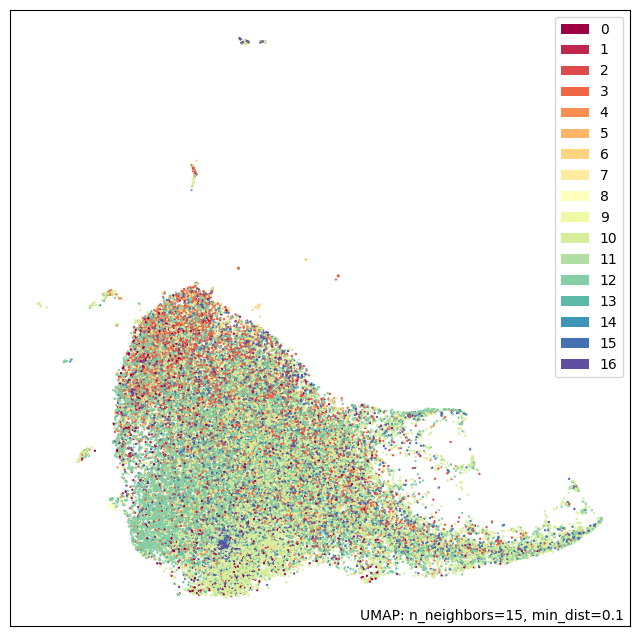

In [25]:
label_encoder = LabelEncoder()
umap_data['category'] = label_encoder.fit_transform(umap_data['category'])
umap_data['sub_category'] = label_encoder.fit_transform(umap_data['sub_category'])

uplot.points(embedding_mapper, labels=umap_data['category'], cmap='viridis')

<Axes: >

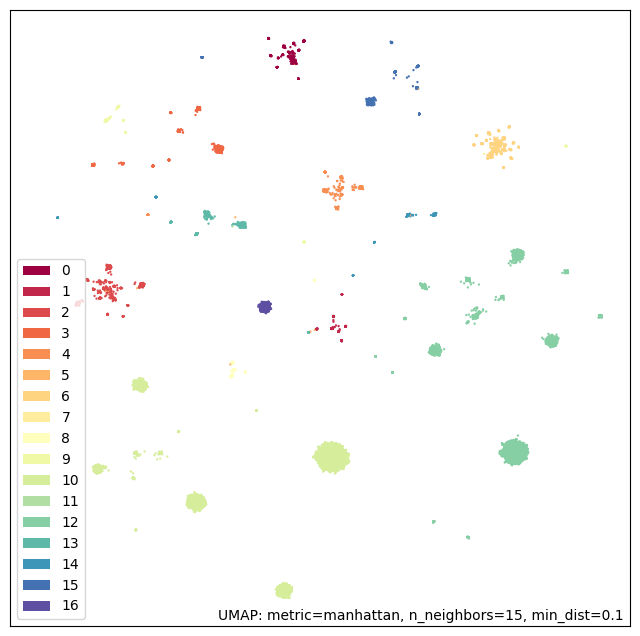

In [24]:
uplot.points(ordinal_mapper, labels=umap_data["category"])

In [26]:
intersection_mapper = embedding_mapper * ordinal_mapper

<Axes: >

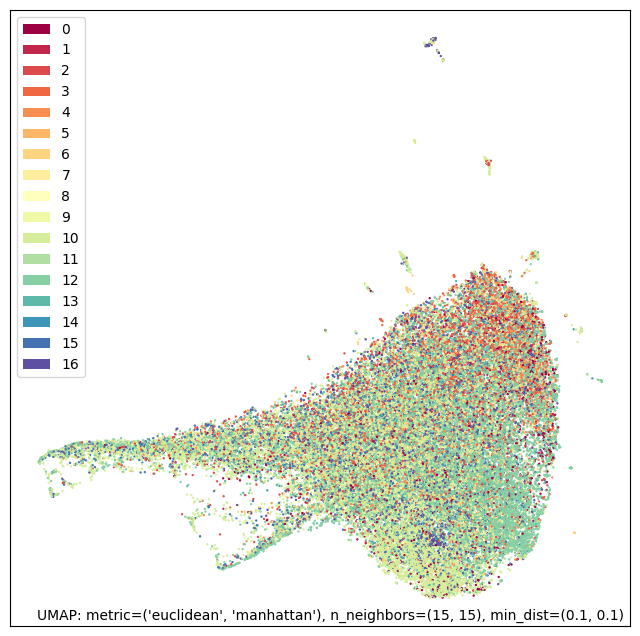

In [28]:
uplot.points(intersection_mapper, labels=umap_data["category"], cmap="viridis")

In [29]:
union_mapper = embedding_mapper + ordinal_mapper

<Axes: >

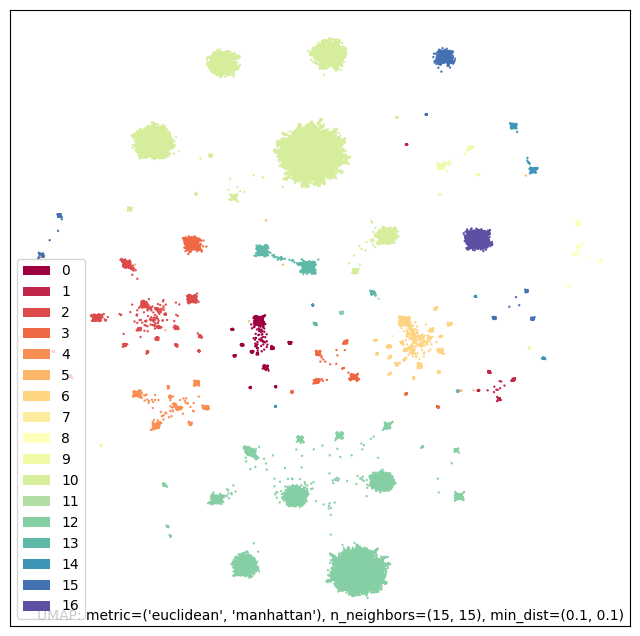

In [30]:
uplot.points(union_mapper, labels=umap_data["category"], cmap="viridis")


In [36]:
kmeans_embedding_labels = cluster.KMeans(n_clusters=16).fit_predict(umap_data[abstracts.columns.to_list() + titles.columns.to_list()])

<Axes: >

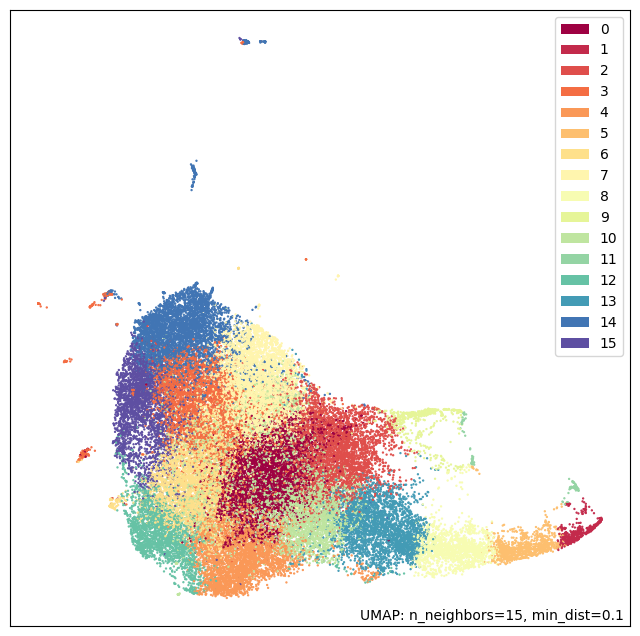

In [37]:

uplot.points(embedding_mapper, labels=kmeans_embedding_labels, cmap="viridis")


In [38]:
print(adjusted_rand_score(umap_data.category, kmeans_embedding_labels), adjusted_mutual_info_score(umap_data.category, kmeans_embedding_labels))

0.019156382560034903 0.053613717146133735


In [42]:
import hdbscan

In [43]:
low_dimensional_news = PCA().fit_transform(umap_data[abstracts.columns.to_list() + titles.columns.to_list()])
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(low_dimensional_news)

In [45]:
embedding_mapper2 = umap.UMAP(random_state=42).fit_transform(umap_data[abstracts.columns.to_list() + titles.columns.to_list()])


c:\Users\nicho\anaconda3\envs\recSysEnv\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


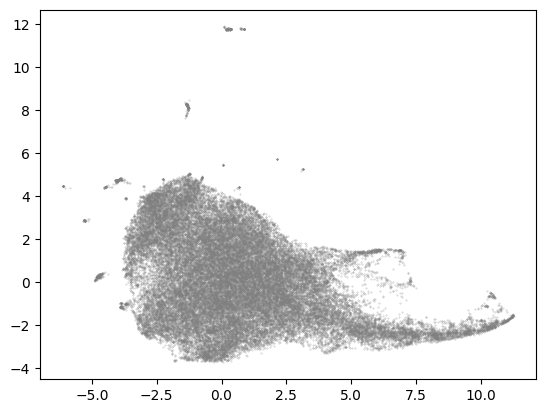

In [46]:
clustered = (hdbscan_labels >= 0)
plt.scatter(embedding_mapper2[~clustered, 0],
            embedding_mapper2[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(embedding_mapper2[clustered, 0],
            embedding_mapper2[clustered, 1],
            c=hdbscan_labels[clustered],
            s=0.1,
            cmap='Spectral');

In [47]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42
).fit_transform(umap_data[abstracts.columns.to_list() + titles.columns.to_list()])

c:\Users\nicho\anaconda3\envs\recSysEnv\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


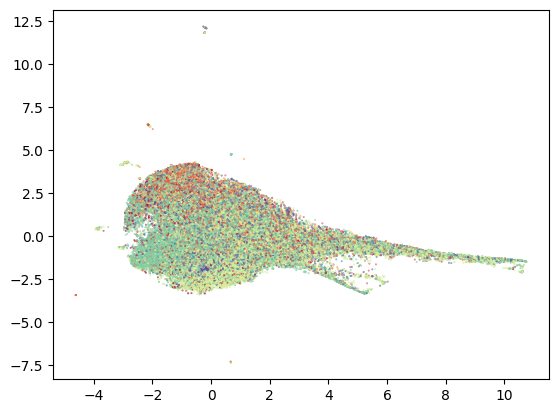

In [48]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], c=umap_data['category'], s=0.1, cmap='Spectral');

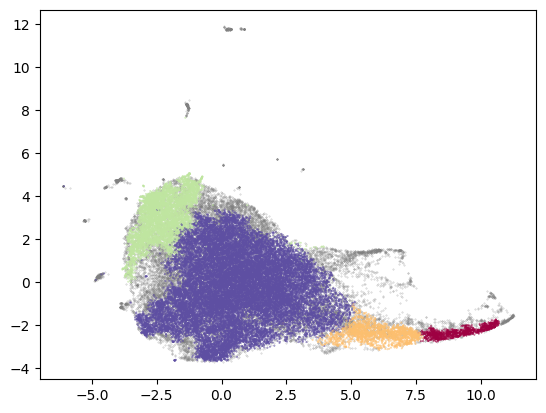

In [49]:
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(clusterable_embedding)
clustered = (labels >= 0)
plt.scatter(embedding_mapper2[~clustered, 0],
            embedding_mapper2[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(embedding_mapper2[clustered, 0],
            embedding_mapper2[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral');

In [57]:
# umap_data[4:].head()
umap_data[umap_data.columns[4:]]

,category_autos,category_entertainment,category_finance,category_foodanddrink,category_health,category_kids,category_lifestyle,category_middleeast,category_movies,category_music,...,6_title,7_title,0_abstract,1_abstract,2_abstract,3_abstract,4_abstract,5_abstract,6_abstract,7_abstract
news_id,,,,,,,,,,,,,,,,,,,,,
N55528,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.181900,0.970425,-1.572779,1.855720,-0.493394,-0.037780,0.728438,0.463786,-1.039312,0.785522
N19639,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-1.181125,0.781984,-1.636491,1.919913,-0.718323,-0.169343,0.932392,0.515101,-1.063485,0.590943
N61837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.886499,0.651225,-1.540791,1.742110,-0.514043,0.012213,0.822090,0.536763,-0.956459,0.794039
N53526,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-1.104852,0.765704,-1.492417,1.875988,-0.799574,0.011016,0.876861,0.520489,-1.161347,0.491944
N38324,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-1.165605,0.754905,-1.424457,1.737304,-0.660647,-0.150412,1.060580,0.657792,-1.176526,0.723498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N17258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.011790,0.779273,-1.502256,1.612378,-0.632217,-0.188314,0.553609,0.614533,-0.899606,0.822706
N23858,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.854597,0.843228,-1.427499,1.624641,-0.751469,-0.263381,0.568501,0.666692,-1.060043,0.781709
N16909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.995483,0.869000,-1.466304,1.802222,-0.592600,-0.217119,0.758318,0.756759,-1.254891,0.903519


c:\Users\nicho\anaconda3\envs\recSysEnv\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


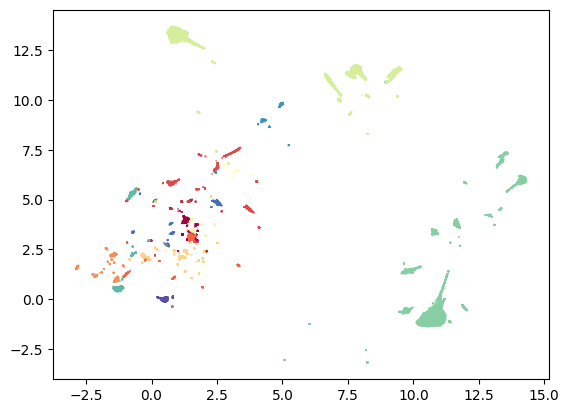

In [59]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=10,
    random_state=42
).fit_transform(umap_data[umap_data.columns[4:]])
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], c=umap_data['category'], s=0.1, cmap='Spectral');
# embedding_mapper = umap.UMAP(random_state=42).fit(umap_data[umap_data.columns[4:]])
# kmeans_embedding_labels = cluster.KMeans(n_clusters=16).fit_predict(umap_data[abstracts.columns.to_list() + titles.columns.to_list()])

In [ ]:

label_encoder = LabelEncoder()
# zeep['category'] = label_encoder.fit_transform(zeep['category'])
standard_embedding = umap.UMAP(random_state=42).fit_transform(zeep[zeep.columns[1:]])
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=zeep['category'], s=0.1, cmap='Spectral');

In [ ]:
kmeans_labels = cluster.KMeans(n_clusters=10).fit_predict(zeep[zeep.columns[1:]])
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans_labels, s=0.1, cmap='Spectral');

